In [1]:
import numpy as np
import pandas as pd

from estival.model import BayesianCompartmentalModel
from estival import priors as esp, targets as est

from summer2.extras import test_models

In [2]:
m = test_models.sirs_parametric_age()

In [3]:
defp = m.get_default_parameters()
defp

{'contact_rate': 0.4,
 'recovery_duration': 10.0,
 'waning_duration': 100.0,
 'cdr': 0.2}

In [ ]:
targetp = defp | {"waning_duration": 20.0, "contact_rate": 0.2}

<Axes: >

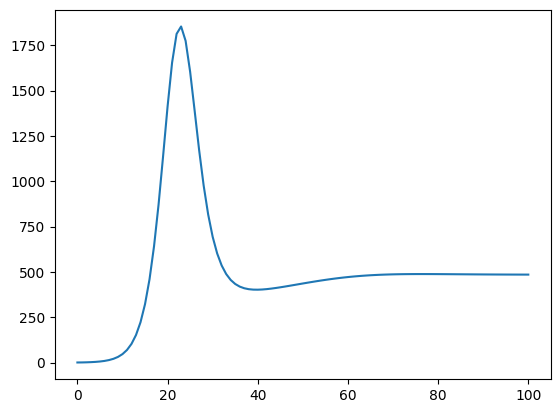

In [4]:
m.run(targetp)
m.get_derived_outputs_df()["notifications"].plot()

In [5]:
m.run(defp | {"waning_duration": 20.0, "contact_rate": 0.2})
targets = [est.NegativeBinomialTarget("notifications", (np.exp(np.random.normal(0.0,0.03, size = (101,))) * m.get_derived_outputs_df()["notifications"]).iloc[::7], 50.0)]

In [6]:
priors = [esp.UniformPrior("cdr", (0.1,1.0)),
          esp.UniformPrior("contact_rate", (0.01,1.0)),
          esp.UniformPrior("recovery_duration", (3.0,20.0)),
          esp.UniformPrior("waning_duration", (10.0,100.0)),
         ]

In [8]:
bcm = BayesianCompartmentalModel(m, parameters=defp, targets=targets, priors=priors)

In [9]:
from estival.sampling import tools as esamp

In [10]:
import pymc as pm
from estival.wrappers import pymc as epm

In [11]:
def find_MAP(sample):
    with pm.Model() as model:
        variables = epm.use_model(bcm)
        map_val = pm.find_MAP(start = sample, progressbar=False, include_transformed=False)
    return {k:float(v) for k,v in map_val.items()}

In [12]:
from estival.wrappers import nevergrad as eng
import nevergrad as ng

In [13]:
def optimize_ng(sample):
    opt = eng.optimize_model(bcm, budget=2000, opt_class=ng.optimizers.TwoPointsDE, suggested = sample, num_workers=4)
    rec= opt.minimize(2000)
    return rec.value[1]

In [14]:
from estival.utils.parallel import map_parallel

In [16]:
from estival.utils.sample import SampleTypes

In [36]:
# Sample 16 points from a Latin Hypercube, then run our nevergrad optimizer over each of them
# Note what we use mode='process' here rather than the default 'thread', since nevergrad does
# a lot of blocking in python code, so multiprocessing helps in this instance

opt_samples = map_parallel(optimize_ng, bcm.sample.lhs(16, SampleTypes.LIST_OF_DICTS), n_workers =4, mode="process")

In [18]:
from estival.sampling import tools as esamp

In [37]:
# Use likelihood_extras_for_samples to obtain detailed
# likelihood information for a set of samples

lle_samps = esamp.likelihood_extras_for_samples(opt_samples, bcm)
lle_samps

,logposterior,logprior,loglikelihood,ll_notifications
sample,,,,
0,-12.012421,-7.217612,-4.794808,-4.794808
1,-12.020156,-7.217612,-4.802544,-4.802544
2,-12.014155,-7.217612,-4.796543,-4.796543
3,-20.988798,-7.217612,-13.771186,-13.771186
4,-12.011982,-7.217612,-4.794370,-4.794370
5,-12.030325,-7.217612,-4.812713,-4.812713
6,-12.008993,-7.217612,-4.791381,-4.791381
7,-14.612131,-7.217612,-7.394519,-7.394519
8,-12.009522,-7.217612,-4.791910,-4.791910


In [38]:
# Sort these by best-first, and grab the index

best_ll_idx = lle_samps.sort_values("logposterior",ascending=False).index

In [39]:
# We'll use the 4 best to init our MCMC
# First convert them to our native SampleIterator type for ease of indexing,
# then use its convert method to get a list of dicts back, which pymc wants for its initvals

init_samps= bcm.sample.convert(opt_samples,SampleTypes.SAMPLEITERATOR)[best_ll_idx].convert(SampleTypes.LIST_OF_DICTS)[0:4]

init_samps

[{'cdr': 0.19194589784055466,
  'contact_rate': 0.20735576387718882,
  'recovery_duration': 8.589914685448356,
  'waning_duration': 19.660048230019665},
 {'cdr': 0.19906083467685587,
  'contact_rate': 0.2018033407479562,
  'recovery_duration': 9.607071825653971,
  'waning_duration': 20.044192393576417},
 {'cdr': 0.1866901159837527,
  'contact_rate': 0.20503441083115198,
  'recovery_duration': 8.998510264641258,
  'waning_duration': 18.58529707549136},
 {'cdr': 0.19667688986207787,
  'contact_rate': 0.20575925554284005,
  'recovery_duration': 8.620856822835197,
  'waning_duration': 20.37242432725946}]

In [22]:
import pymc as pm
from estival.wrappers import pymc as epm

In [23]:
with pm.Model() as model:
    variables = epm.use_model(bcm)
    idata = pm.sample(step=[pm.DEMetropolisZ(variables)],draws=4000, initvals=init_samps)

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [cdr, contact_rate, recovery_duration, waning_duration]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 32 seconds.


In [24]:
import arviz as az

In [25]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cdr,0.280,0.101,0.132,0.470,0.003,0.003,964.0,1064.0,1.00
contact_rate,0.201,0.025,0.160,0.254,0.001,0.001,848.0,795.0,1.00
recovery_duration,11.894,4.662,4.670,19.867,0.158,0.112,838.0,923.0,1.01
waning_duration,29.502,13.748,10.012,53.554,0.469,0.336,871.0,1209.0,1.00


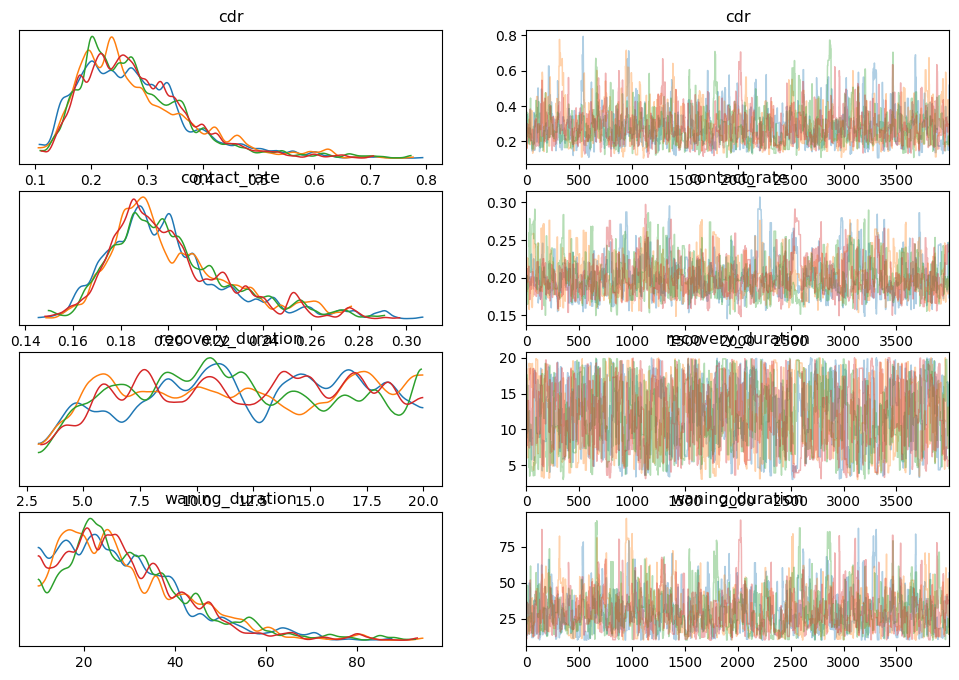

In [26]:
az.plot_trace(idata, compact=False);

In [27]:
# Much like like likelihood_extras_for_samples, likelihood_extras_for_idata
# gives detailed likelihoods for the output of pm.sample

lle = esamp.likelihood_extras_for_idata(idata, bcm)

<Axes: xlabel='draw'>

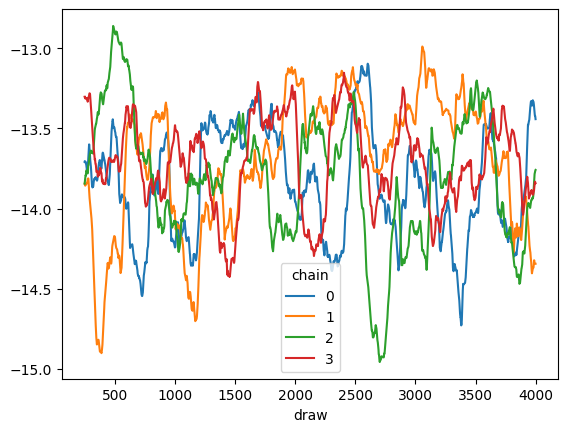

In [28]:
# Check the per chain performance over time
# We'll use a rolling mean to get a clearer picture

lle["logposterior"].unstack(["chain"]).rolling(250).mean().plot()

In [29]:
# Get some randomly drawn samples for spaghetti plots
sds = az.extract(idata, num_samples=20)

In [30]:
spaghetti_res = esamp.model_results_for_samples(sds,bcm)

<Axes: xlabel='time'>

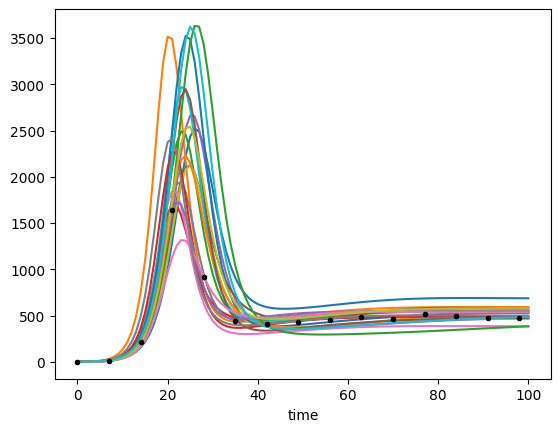

In [31]:
spaghetti_res.results["notifications"].plot(legend=False)
bcm.targets["notifications"].data.plot(style='.',color="black")

In [32]:
# Extract a more comprehensive set of samples for uncertainty

sds = az.extract(idata, num_samples=500)

In [33]:
samp_res = esamp.model_results_for_samples(sds,bcm)

In [34]:
quantiles = esamp.quantiles_for_results(samp_res.results, (0.05,0.25,0.5,0.75,0.95))

<Axes: xlabel='time'>

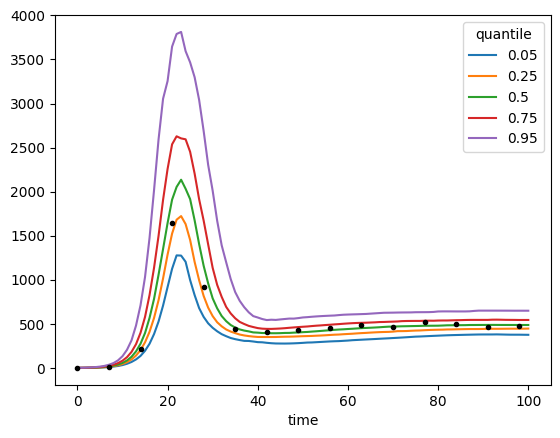

In [35]:
quantiles["notifications"].plot()
bcm.targets["notifications"].data.plot(style='.',color="black")